### 导入库

In [1]:
import torch
from torch.utils import data
import torchvision
from torchvision import transforms
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from data import LoadData
from model import VGG16
from utils import *
from loss import EdgeSaliencyLoss

for name in (torch, torchvision, cv2, np):
    print(name.__version__)

1.6.0+cu101
0.7.0+cu101
4.3.0
1.19.1


### 使用GPU或者CPU

In [2]:
if torch.cuda.is_available():
    device = torch.device(device='cuda')
else:
    device = torch.device(device='cpu')
device

device(type='cuda')

In [3]:
path_image = "./DUTS/DUTS-TR/DUTS-TR-Image/"
path_mask = "./DUTS/DUTS-TR/DUTS-TR-Mask/"

In [4]:
batch_size = 4 #受限于贫穷，4是极限了
learning_rate = 1e-6
target_size = 256
epochs = 1

In [5]:
data_loader = data.DataLoader(LoadData(path_image, path_mask, target_size),
                            batch_size=batch_size,
                            shuffle=True)

In [6]:
total_batch = len(data_loader)
total_batch

2639

### 导入模型

In [7]:
model = VGG16()

In [9]:
model.load_state_dict(torch.load("./model/model_23.pth"), strict=False)

<All keys matched successfully>

In [10]:
model.eval()
model.to(device)
criterion = EdgeSaliencyLoss(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0, momentum=0.9)

In [11]:
for epoch in range(epochs):
    start_time = time.time()
    model.train()
    
    total_loss = 0
    total_acc = 0
    total_pre = 0
    total_rec = 0
    total_f_score = 0
    
    for batch_n, (image, mask) in enumerate(data_loader, start=1):
        
        image = image.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predict = model(image)
        loss = criterion(predict, mask)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_loss += loss.item()
            acc = accuracy(predict, mask)
            total_acc += acc

            pre = precision(predict, mask)
            total_pre += pre

            rec = recall(predict, mask)
            total_rec += rec

            f_score = F_Measure(pre, rec)
            total_f_score += f_score
        
        
        if batch_n % 100 == 0:
            with torch.no_grad():
                avg_acc = total_acc / batch_n
                avg_pre = total_pre / batch_n
                avg_rec = total_rec / batch_n
                avg_f_score = total_f_score / batch_n
                print("Epoch:{} loss:{} Batch:{}/{}".format(epoch + 1, loss.item(), batch_n, total_batch), end="")
                print(" acc:{} pre:{} recall:{} F-measure:{}"
                      .format(avg_acc, avg_pre, avg_rec, avg_f_score))
    end_time = time.time()
    print("--------------------------------------------------------------")
    print("Epoch {} time:{:.2f}s END :loss:{} acc:{} pre:{} rec:{} F-measure:{}"
          .format(epoch + 1, 
                  end_time - start_time,
                  total_loss / total_batch, 
                  total_acc / total_batch,
                  total_pre / total_batch,
                  total_rec / total_batch,
                  total_f_score / total_batch))
    print("--------------------------------------------------------------")

Epoch:1 loss:0.21461138129234314 Batch:100/2639 acc:0.9141505360603333 pre:0.8630205988883972 recall:0.894669234752655 F-measure:0.8669778108596802
Epoch:1 loss:0.225614532828331 Batch:200/2639 acc:0.9135688543319702 pre:0.86378014087677 recall:0.9025779366493225 F-measure:0.869678795337677
Epoch:1 loss:0.1766064614057541 Batch:300/2639 acc:0.9138908386230469 pre:0.8669660687446594 recall:0.9039732217788696 F-measure:0.8728329539299011
Epoch:1 loss:0.20140033960342407 Batch:400/2639 acc:0.914983868598938 pre:0.8692139983177185 recall:0.9054887890815735 F-measure:0.8751189708709717
Epoch:1 loss:0.19342750310897827 Batch:500/2639 acc:0.9152161478996277 pre:0.8703791499137878 recall:0.9059321284294128 F-measure:0.8762602210044861
Epoch:1 loss:0.1372704952955246 Batch:600/2639 acc:0.915815532207489 pre:0.8709778189659119 recall:0.9070389866828918 F-measure:0.8770045042037964
Epoch:1 loss:0.1634955257177353 Batch:700/2639 acc:0.9154742956161499 pre:0.8707720637321472 recall:0.90657329559326

In [12]:
torch.save(model.state_dict(),"./model/model_24.pth")

In [13]:
def pad_resize_image(inp_img, out_img=None, target_size=None):
    h, w, c = inp_img.shape
    size = max(h, w)

    padding_h = (size - h) // 2
    padding_w = (size - w) // 2

    if out_img is None:
        # For inference
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x
    else:
        # For training and testing
        temp_x = cv2.copyMakeBorder(inp_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        temp_y = cv2.copyMakeBorder(out_img, top=padding_h, bottom=padding_h, left=padding_w, right=padding_w,
                                    borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        # print(inp_img.shape, temp_x.shape, out_img.shape, temp_y.shape)

        if target_size is not None:
            temp_x = cv2.resize(temp_x, (target_size, target_size), interpolation=cv2.INTER_AREA)
            temp_y = cv2.resize(temp_y, (target_size, target_size), interpolation=cv2.INTER_AREA)
        return temp_x, temp_y


In [14]:
def getInput(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype('float32')
    
    img = pad_resize_image(img, target_size=256)
    img /= 255.
    img = np.transpose(img, axes=(2, 0, 1))
    img = torch.from_numpy(img).float()
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]) 
    
    img = normalize(img)
    return img

In [15]:
img = getInput("./image/1.jpg")

In [16]:
img.shape

torch.Size([3, 256, 256])

In [17]:
img = img.reshape(1, 3, 256, 256)
img = img.to(device)

In [18]:
predict = model(img)

In [19]:
predict.shape

torch.Size([1, 1, 256, 256])

In [20]:
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

In [21]:
msk.shape

torch.Size([256, 256, 1])

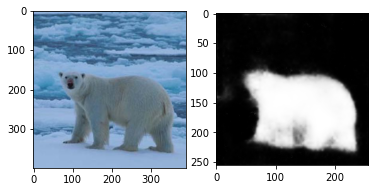

In [22]:
msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

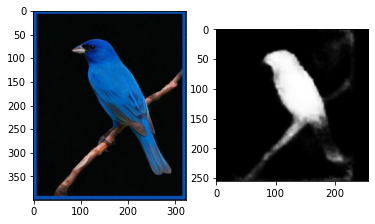

In [23]:
img = getInput("./image/2.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

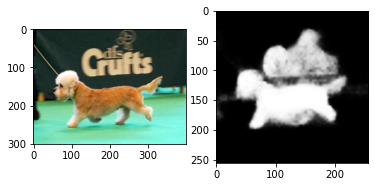

In [24]:
img = getInput("./image/3.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./image/3.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(msk, cmap='gray')
plt.show()

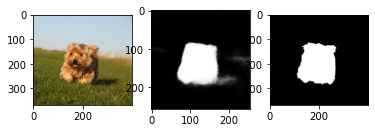

In [25]:
img = getInput("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = img.reshape(1, 3, 256, 256)
img = img.to(device)
predict = model(img)
msk = predict.reshape(256, 256, 1)
msk = msk.cpu().detach()

msk = np.array(msk, dtype=np.float32)
img = cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Image/ILSVRC2012_test_00000004.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(msk, cmap='gray')
plt.subplot(133)
plt.imshow(cv2.imread("./DUTS/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000004.png"))
plt.show()